In [1]:
path=  'C:/Users/felipe/Documents/Brain/'

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import StratifiedKFold

from sklearn.preprocessing import MinMaxScaler
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import shap
from sklearn.linear_model import LinearRegression
import seaborn as sns
import os
from joblib import dump, load
import pickle

from nilearn import plotting
import statsmodels.api as sm
from sklearn.model_selection import StratifiedShuffleSplit

c:\Users\felipe\Documents\Brain\brain_age_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file_name = 'Brain_Age/dataframe_alpha.xlsx'
file_path = f"{path}{file_name}"

df = pd.read_excel(file_path)
# Filtrar las filas con Age mayor de 20
df_filtrado = df[df['Age'] > 20].reset_index(drop=True)
X = df_filtrado.drop(columns=["Unnamed: 0", "Age"])
y = df_filtrado["Age"]

In [4]:
import xgboost as xgb

# Búsqueda hiperparámetros

In [ ]:
model = xgb.XGBRegressor()

params_space = {
                'n_estimators': Integer(50, 5000),
                'learning_rate': Real(0.0001, 0.2, prior='log-uniform'),
                'max_depth': Integer(3, 10),
                'subsample': Real(0.1, 1.0),
                'colsample_bytree': Real(0.1, 1.0)
            }

kf = KFold(n_splits=10, shuffle=True, random_state=126)

fit_param = {
    'early_stopping_rounds': 10,
}

opt_model = BayesSearchCV(
            estimator=model,
            search_spaces=params_space,
            fit_params=fit_param,
            cv=kf,
            n_iter=10,
            scoring='neg_mean_absolute_error',
            n_jobs=-1,
            random_state=42,
            verbose=1
        )


opt_model.fit(X, y)

In [6]:
with open(f'{path}Opt_Model/opt_XGB_model_400iter.pickle', 'rb') as file:
    opt_model= pickle.load(file)

In [7]:
print(opt_model.best_score_)
print(opt_model.best_params_)
results = pd.DataFrame(opt_model.cv_results_)
best_params = opt_model.best_params_

-12.780233929998849
OrderedDict({'colsample_bytree': 0.6, 'learning_rate': 0.01675572119197379, 'max_depth': 7, 'n_estimators': 550, 'subsample': 0.6})


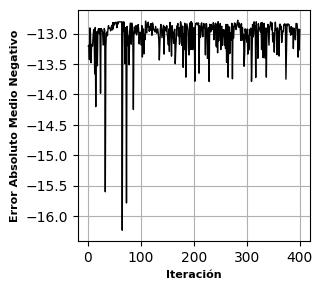

In [8]:
errores =opt_model.cv_results_['mean_test_score']
iteraciones = list(range(1, len(errores) + 1))
plt.figure(figsize=(3, 3))
plt.plot(iteraciones, errores,  linestyle='-', color='black', alpha=1,linewidth=1)
plt.xlabel('Iteración', fontweight='bold', fontsize=8)
plt.ylabel('Error Absoluto Medio Negativo', fontweight='bold', fontsize=8)
plt.grid(True)
plt.show()  

# Trainer

In [9]:
best_params_100 = opt_model.cv_results_['params'][np.argmax(opt_model.cv_results_['mean_test_score'][:100])]


In [10]:
best_params_100

OrderedDict([('colsample_bytree', 0.6),
             ('learning_rate', 0.01),
             ('max_depth', 5),
             ('n_estimators', 660),
             ('subsample', 0.6)])

In [11]:
def regression_metrics( y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2


scaler = MinMaxScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)
X_scaled_= pd.DataFrame(X_scaled, columns=X.columns)

X_train, X_test, y_train, y_test = train_test_split(X_scaled_, y, test_size=0.2, random_state=1)

# Sin correccion

In [ ]:
best_fold = 0
best_score = float('inf')
best_model = None

metrics = ['mae', 'mse', 'rmse', 'r2']
results = {'train': {m: [] for m in metrics}, 
           'val': {m: [] for m in metrics}, 
           'test': {m: [] for m in metrics},
           'model': []}

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=126)

model_ml = xgb.XGBRegressor()

early_stopping_rounds = 10  # Número de rondas para detenerse si no hay mejora

for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    model = xgb.XGBRegressor(**best_params_100)
    
    # Ajustar el modelo con early stopping
    model.fit(X_train_kf, y_train_kf,
              eval_set=[(X_test, y_test)],
              eval_metric="mae",
              early_stopping_rounds=early_stopping_rounds, 
              verbose=False)  

    y_pred_train = model.predict(X_train_kf)
    train_metrics = regression_metrics(y_train_kf, y_pred_train)

    y_pred_val = model.predict(X_val_kf)
    val_metrics = regression_metrics(y_val_kf, y_pred_val)

    y_pred_test = model.predict(X_test)
    test_metrics = regression_metrics(y_test, y_pred_test)

    # Almacenar los resultados de las métricas
    for ds in ['train', 'val', 'test']:
        if ds == 'train':
            metrics_set = train_metrics
        elif ds == 'val':
            metrics_set = val_metrics
        else:
            metrics_set = test_metrics
            
        for i, metric in enumerate(metrics):
            results[ds][metric].append(metrics_set[i])
    
    # Almacenar el modelo
    results['model'].append(model)

    mae = val_metrics[0]
    if mae < best_score:
        best_fold = fold
        best_score = mae
        best_model = model


In [ ]:
best_fold = 0
best_score = float('inf')
best_model = None

metrics = ['mae', 'mse', 'rmse', 'r2']
results = {'train': {m: [] for m in metrics}, 
           'val': {m: [] for m in metrics}, 
           'test': {m: [] for m in metrics},
           'model': []}

n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=126)

model_ml = xgb.XGBRegressor()

early_stopping_rounds = 10  # Número de rondas para detenerse si no hay mejora

for fold, (train_index, test_index) in enumerate(kf.split(X_train, y_train)):
    X_train_kf, X_val_kf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_kf, y_val_kf = y_train.iloc[train_index], y_train.iloc[test_index]

    model = xgb.XGBRegressor(**best_params_100)
    
    # Ajustar el modelo con early stopping
    model.fit(X_train_kf, y_train_kf,
              eval_set=[(X_test, y_test)],
              eval_metric="mae",
              early_stopping_rounds=early_stopping_rounds, 
              verbose=False)

    y_pred_train = model.predict(X_train_kf)
    y_pred_val = model.predict(X_val_kf)
    y_pred_test = model.predict(X_test)


    train_residuals = y_pred_train - y_train_kf.to_numpy()
    residual_model = LinearRegression()
    residual_model.fit(y_train_kf.to_numpy().reshape(-1, 1), train_residuals)
    correction_val = residual_model.predict(y_val_kf.to_numpy().reshape(-1, 1))
    correction_test = residual_model.predict(y_test.to_numpy().reshape(-1, 1))

    y_pred_adjusted_val = y_pred_val - correction_val
    y_pred_adjusted_test = y_pred_test - correction_test


    train_metrics = regression_metrics(y_train_kf, y_pred_train)
    val_metrics = regression_metrics(y_val_kf, y_pred_adjusted_val)
    test_metrics = regression_metrics(y_test, y_pred_adjusted_test)

    # Almacenar los resultados de las métricas
    for ds in ['train', 'val', 'test']:
        if ds == 'train':
            metrics_set = train_metrics
        elif ds == 'val':
            metrics_set = val_metrics
        else:
            metrics_set = test_metrics
            
        for i, metric in enumerate(metrics):
            results[ds][metric].append(metrics_set[i])
    
    # Almacenar el modelo
    results['model'].append(model)

    mae = val_metrics[0]
    if mae < best_score:
        best_fold = fold
        best_score = mae
        best_model = model


In [13]:
results

{'train': {'mae': [6.619095726526948,
   6.739630845753464,
   7.555666292551749,
   7.618821431842269,
   7.099013842118536,
   7.617809921172264,
   6.913222251658563,
   6.8636512467647055,
   7.375185073123731,
   6.034290635782262],
  'mse': [67.47861576823651,
   69.9220351076351,
   87.29691880899583,
   88.73001846057383,
   78.1390377202688,
   89.1040417695751,
   74.29361547939197,
   72.14024670561564,
   84.14086857093685,
   57.55330258695055],
  'rmse': [8.214536856587626,
   8.36193967376201,
   9.343282014848734,
   9.41966127101043,
   8.839628822539371,
   9.439493724219277,
   8.619374425060787,
   8.49354147017695,
   9.172833181244323,
   7.586389298404779],
  'r2': [0.8334588491401722,
   0.8239856887745874,
   0.7810619282388221,
   0.7792238229932655,
   0.8054034623566075,
   0.7749505863226163,
   0.813034831478002,
   0.8192210243774013,
   0.7922135938476907,
   0.8568129777909345]},
 'val': {'mae': [9.141362529013351,
   9.200941376935432,
   7.83593601655

In [ ]:
y_pred_test=best_model.predict(X_test)
train_residuals = y_pred_train - y_train.to_numpy()


In [124]:
y_pred_train=best_model.predict(X_train)
y_pred_test=best_model.predict(X_test)

train_residuals = y_pred_train - y_train.to_numpy()
residual_model = LinearRegression()
residual_model.fit(y_train.to_numpy().reshape(-1, 1), train_residuals)
correction = residual_model.predict(y_test.to_numpy().reshape(-1, 1))
y_pred_adjusted = y_pred_test - correction


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.453
Model:                            OLS   Adj. R-squared:                  0.451
Method:                 Least Squares   F-statistic:                     227.3
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           8.19e-38
Time:                        20:52:07   Log-Likelihood:                -995.68
No. Observations:                 276   AIC:                             1995.
Df Residuals:                     274   BIC:                             2003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         29.8494      1.378     21.656      0.0

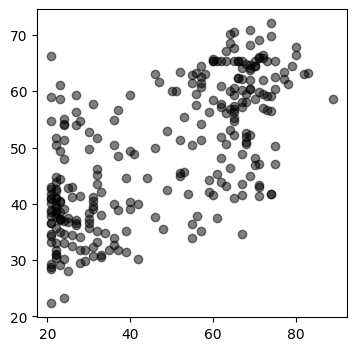

In [125]:
plt.figure(figsize=(4, 4))
x_test_with_constant = sm.add_constant(y_test)  # Agregar constante (intercepto)
linear_model = sm.OLS(y_pred_test, x_test_with_constant).fit()
print(linear_model.summary())
plt.scatter(y_test, y_pred_test, alpha=0.5, color='black')
plt.show()
        

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.809
Model:                            OLS   Adj. R-squared:                  0.809
Method:                 Least Squares   F-statistic:                     4651.
Date:                Thu, 22 Aug 2024   Prob (F-statistic):               0.00
Time:                        20:52:10   Log-Likelihood:                -3561.3
No. Observations:                1101   AIC:                             7127.
Df Residuals:                    1099   BIC:                             7137.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         18.3243      0.496     36.920      0.0

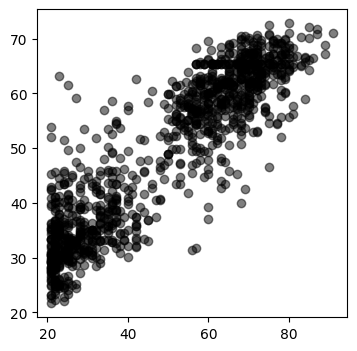

In [126]:
plt.figure(figsize=(4, 4))
x_train_with_constant = sm.add_constant(y_train)  # Agregar constante (intercepto)
linear_model = sm.OLS(y_pred_train, x_train_with_constant).fit()
print(linear_model.summary())
plt.scatter(y_train, y_pred_train, alpha=0.5, color='black')
plt.show()
        

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.752
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     830.5
Date:                Thu, 22 Aug 2024   Prob (F-statistic):           6.34e-85
Time:                        20:52:13   Log-Likelihood:                -995.68
No. Observations:                 276   AIC:                             1995.
Df Residuals:                     274   BIC:                             2003.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         11.5251      1.378      8.362      0.0

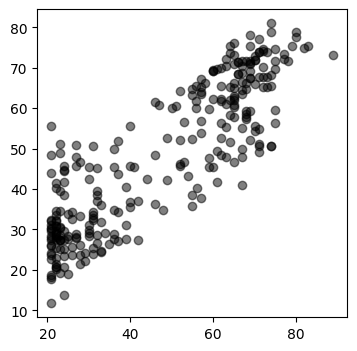

In [127]:
plt.figure(figsize=(4, 4))
x_test_with_constant = sm.add_constant(y_test)  # Agregar constante (intercepto)
linear_model = sm.OLS(y_pred_adjusted, x_test_with_constant).fit()
print(linear_model.summary())
plt.scatter(y_test, y_pred_adjusted, alpha=0.5, color='black')
plt.show()
        

# SHAP

In [128]:
try:
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)
except Exception as e:
    print("Fallo al usar shap.Explainer, intentando con shap.KernelExplainer:", e)
    try:
        explainer = shap.KernelExplainer(model.predict, shap.sample(X_train, 5), num_jobs=-1)
        shap_values = explainer.shap_values(X_test)
    except Exception as kernel_e:
        print("Fallo al usar shap.KernelExplainer:", kernel_e)

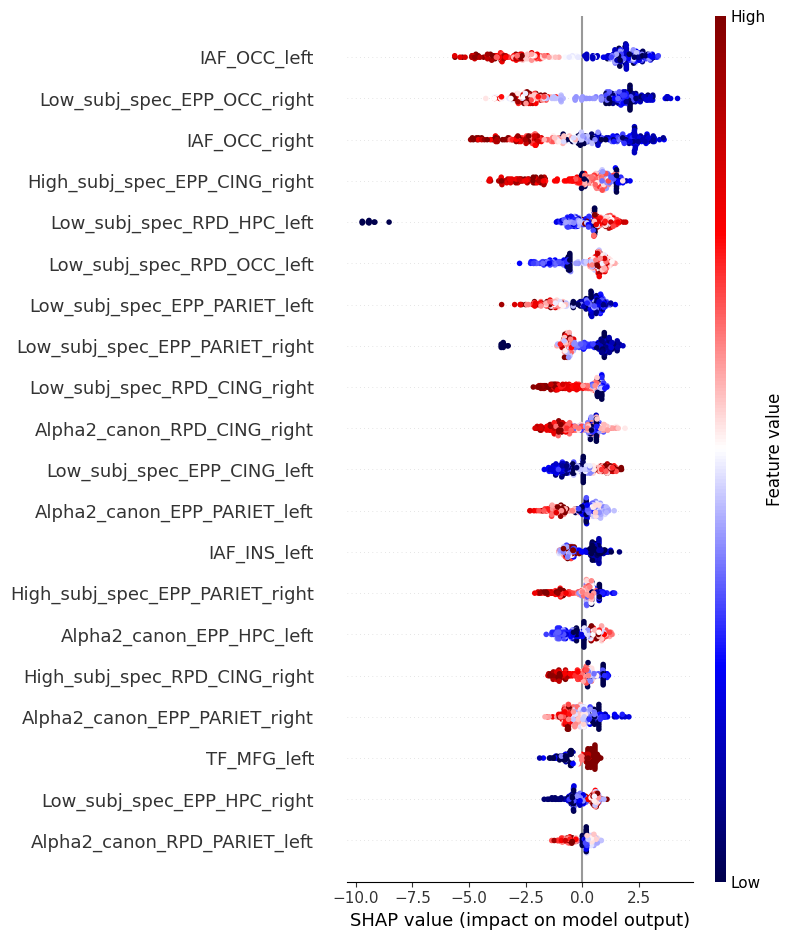

In [131]:
shap.summary_plot(shap_values, X_test, cmap=sns.color_palette("seismic", as_cmap=True), show=False)

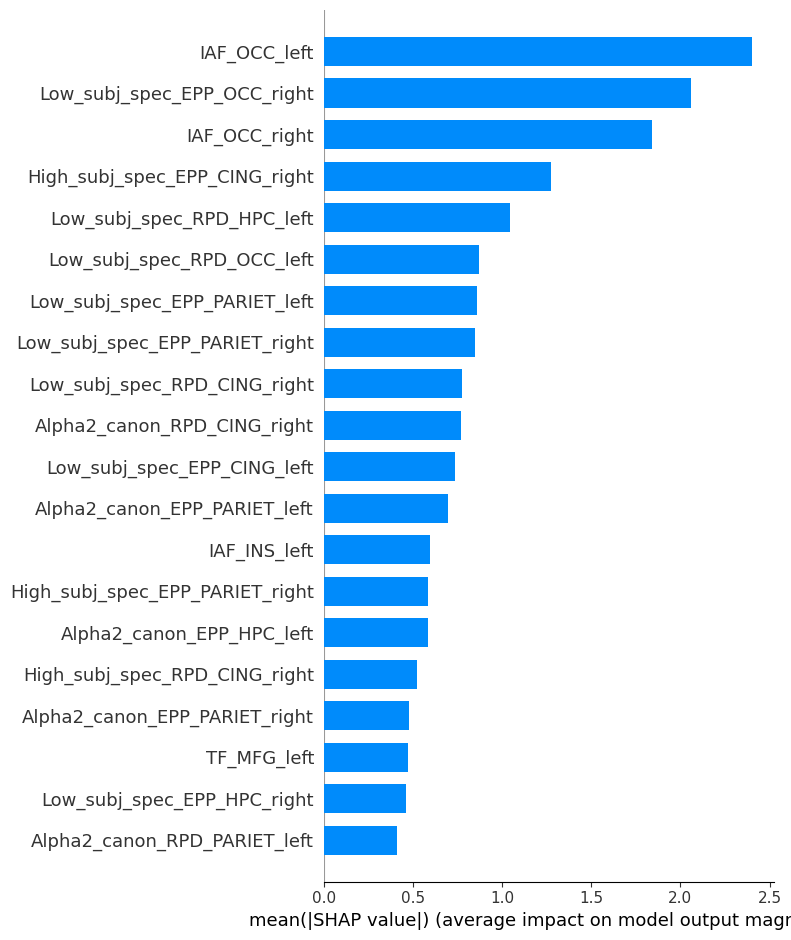

In [132]:
shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
